<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/CPRAVG_SARIMAX_DAILY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
%pip install pmdarima

In [223]:
import pandas as pd
import numpy as np
%matplotlib inline
import pmdarima as pm

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [224]:
path = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(path)
df = df.dropna()
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.index = date_time
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
Date Time,,,,,,,,,,,,
2009-01-01 00:10:00,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700
2009-01-01 00:20:00,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066
2009-01-01 00:30:00,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841
2009-01-01 00:40:00,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223
2009-01-01 00:50:00,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023


In [225]:
number_of_days = (df.shape[0]//144)+1 #// for integer division
number_of_extra_rows = df.shape[0]%144
df_days = df.rolling(144).mean().dropna()
df_days = df_days.iloc[::144,:]
df_extra = df[86*144:df.shape[0]].mean()
df_days = df_days.append(df_extra,ignore_index=True)
df_days

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH
0,0.437426,18.989021,4.212129,32.006993,0.010173,30654.824301,830.488018,640.112469,0.469527,0.794234,-4.467693,75.694686
1,0.448062,18.809630,4.524849,33.836544,0.010565,30625.732653,844.455551,651.105717,0.469758,0.469703,-4.170596,75.561543
2,0.450353,19.083289,4.726570,34.668045,0.012945,30705.664307,852.964052,657.452192,0.470218,0.333544,-4.249914,75.352648
3,0.451834,18.531180,4.659772,34.896273,0.012922,30713.556058,854.393941,659.299923,0.469249,0.274911,-4.314996,75.919100
4,0.452508,17.260066,4.367844,34.849715,0.013748,30754.496406,854.443389,659.779801,0.469077,0.319588,-4.264858,77.543971
...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.516196,22.787623,4.144163,32.998388,0.012000,28634.796591,853.104591,651.138966,0.487782,0.976843,-4.962001,71.868771
83,0.516829,24.152432,4.141898,31.950313,0.012233,28754.501818,853.112442,650.101372,0.488156,1.030537,-4.959895,70.069474
84,0.517241,23.390510,4.132008,32.028396,0.012171,28687.527385,853.108998,651.155280,0.488213,1.037697,-4.961618,71.159993
85,0.517645,23.003283,4.141829,31.995858,0.012024,28685.423422,853.136709,651.738798,0.488620,0.917159,-4.959742,71.677207


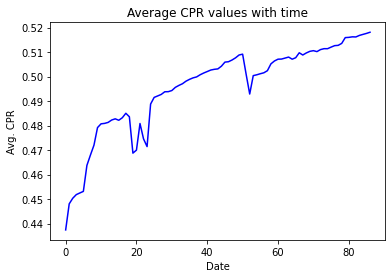

In [226]:
df = df_days
#Plotting the CPRAVG data

import matplotlib.pyplot as plt
plt.title('Average CPR values with time')
plt.xlabel('Date')
plt.ylabel('Avg. CPR')
plt.plot(df['CPRAVG'],color = 'blue')

In [227]:
#Printing list of columns:
cols = list(df)[0:df.shape[1]]
print(cols)

['CPRAVG', 'PROP', 'BUT', 'ETHYLENE', 'AI12201M', 'FLW', 'COT', 'TEMP', 'PRESS', 'O2', 'DRAFT', 'ETH']


In [228]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [229]:
adf_test(df['CPRAVG'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.420242
p-value                  0.136105
# lags used              3.000000
# observations          83.000000
critical value (1%)     -3.511712
critical value (5%)     -2.897048
critical value (10%)    -2.585713
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


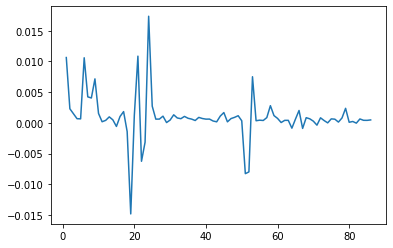

In [230]:
#Differencing the data.
diff_df = df['CPRAVG'].diff().dropna()
plt.plot(diff_df)

In [231]:
adf_test(diff_df)

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.641650
p-value                  0.000108
# lags used              2.000000
# observations          83.000000
critical value (1%)     -3.511712
critical value (5%)     -2.897048
critical value (10%)    -2.585713
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


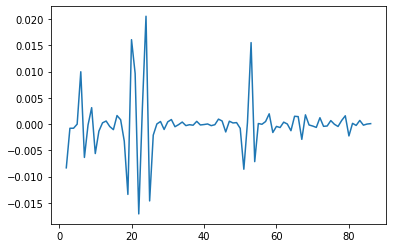

In [232]:
#Second Differencing the data.
diff_df2 = diff_df.diff().dropna()
plt.plot(diff_df2)

In [233]:
adf_test(diff_df2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.887973e+00
p-value                 4.515884e-12
# lags used             3.000000e+00
# observations          8.100000e+01
critical value (1%)    -3.513790e+00
critical value (5%)    -2.897943e+00
critical value (10%)   -2.586191e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


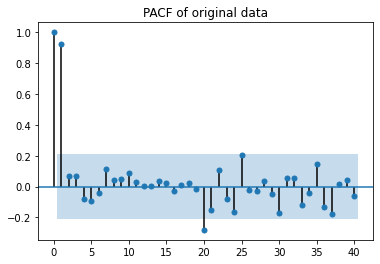

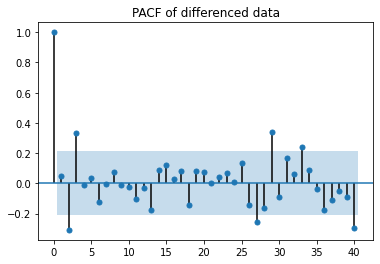

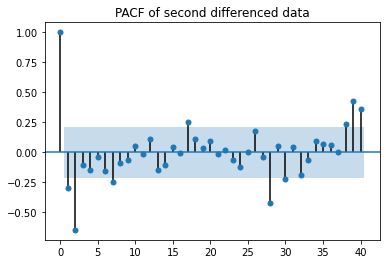

In [234]:
#PACF
plot_pacf(df['CPRAVG'],lags = 40)
plt.title('PACF of original data')
plt.show()

plot_pacf(diff_df,lags = 40)
plt.title('PACF of differenced data')
plt.show()

plot_pacf(diff_df2,lags = 40)
plt.title('PACF of second differenced data')
plt.show()

In [235]:
auto_arima(df['CPRAVG'],max_p=10,max_d=10,max_q=10,seasonal=False,m=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   87
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 368.872
Date:                Fri, 13 Aug 2021   AIC                           -723.743
Time:                        08:24:12   BIC                           -706.563
Sample:                             0   HQIC                          -716.829
                                 - 87                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.528      0.127      -0.000       0.003
ar.L1         -0.1924      0.759     -0.254      0.800      -1.680       1.295
ma.L1          0.4094      0.753      0.544      0.587      -1.067       1.886
ma.L2         -0.2740      0.146     -1.877      0.061      -0.560       0.012
ma.L3          0.1454      0.228      0.638      0.523      -0.301       0.592
ma.L4          0.2322      0.107      2.178      0.029       0.023       0.441
sigma2      1.091e-05   9.38e-07     11.629      0.000    9.07e-06    1.27e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               187.34
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
#Splitting the data:
split_length = 0.91
train_df = df[0:int(split_length*df.shape[0])]
val_df = df[int(split_length*df.shape[0]):df.shape[0]]

In [242]:
# auto_arima(train_df['CPRAVG'],max_p=10,max_d=10,max_q=10,seasonal=False,m=1).summary()

In [258]:
model = SARIMAX(train_df['CPRAVG'],exog = train_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']],order=(2,2,8),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 CPRAVG   No. Observations:                   79
Model:               SARIMAX(2, 2, 8)   Log Likelihood                 398.323
Date:                Fri, 13 Aug 2021   AIC                           -758.645
Time:                        08:25:31   BIC                           -714.113
Sample:                             0   HQIC                          -740.833
                                 - 79                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PROP          -0.0002      0.000     -0.908      0.364      -0.001       0.000
BUT            0.0015      0.001      2.617      0.009       0.000       0.003
FLW        -5.597e-06   2.42e-07    -23.100      0.000   -6.07e-06   -5.12e-06
COT            0.0002   9.37e-05      1.963      0.050    2.58e-07       0.000
TEMP           0.0002   7.51e-05      2.882      0.004    6.93e-05       0.000
PRESS          0.1327      0.041      3.219      0.001       0.052       0.213
DRAFT          0.0038      0.001      3.120      0.002       0.001       0.006
ETH           -0.0001      0.000     -0.726      0.468      -0.000       0.000
ar.L1         -0.7799      0.273     -2.859      0.004      -1.315      -0.245
ar.L2         -0.3810      0.390     -0.978      0.328      -1.145       0.383
ma.L1          0.0903      0.257      0.351      0.726      -0.414       0.595
ma.L2         -0.2164      0.598     -0.362      0.718      -1.389       0.956
ma.L3         -0.4486      0.261     -1.716      0.086      -0.961       0.064
ma.L4         -0.1464      0.163     -0.896      0.370      -0.467       0.174
ma.L5         -0.0874      0.209     -0.419      0.676      -0.497       0.322
ma.L6          0.0410      0.134      0.306      0.760      -0.222       0.304
ma.L7         -0.1050      0.159     -0.658      0.510      -0.417       0.207
ma.L8          0.0715      0.189      0.378      0.705      -0.299       0.442
sigma2      1.118e-06   1.32e-07      8.499      0.000     8.6e-07    1.38e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                27.32
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.47
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.54e+17. Standard errors may be unstable.
"""

In [259]:
start=len(train_df)
end=df.shape[0]-1
exog_forecast= val_df[['PROP', 'BUT', 'FLW', 'COT', 'TEMP', 'PRESS', 'DRAFT', 'ETH']] 
predictions = results.predict(start=start, end=end, exog=exog_forecast,dynamic = True).rename('SARIMAX(1,1,4) Predictions')

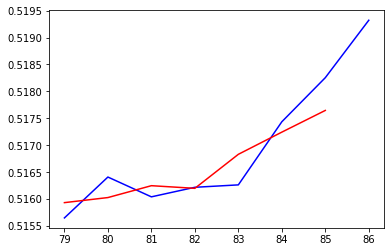

In [260]:
plt.plot(predictions, color = 'blue')
plt.plot(df['CPRAVG'][start:end], color = 'red')